                                   Demo for Nexperia Project

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

The original path for Nexperia Image: read and shuffle

In [2]:
path_pass='/home/share/NexperiaImage/Pass/'
path_overkill='/home/share/NexperiaImage/Overkill/'
path_rej='/home/share/NexperiaImage/Reject/'
pass_img=os.listdir(path_pass)
overkill_img=os.listdir(path_overkill)
rej_img=os.listdir(path_rej)
#np.random.seed(0)
np.random.shuffle(pass_img)
np.random.shuffle(overkill_img)
np.random.shuffle(rej_img)

Show one example

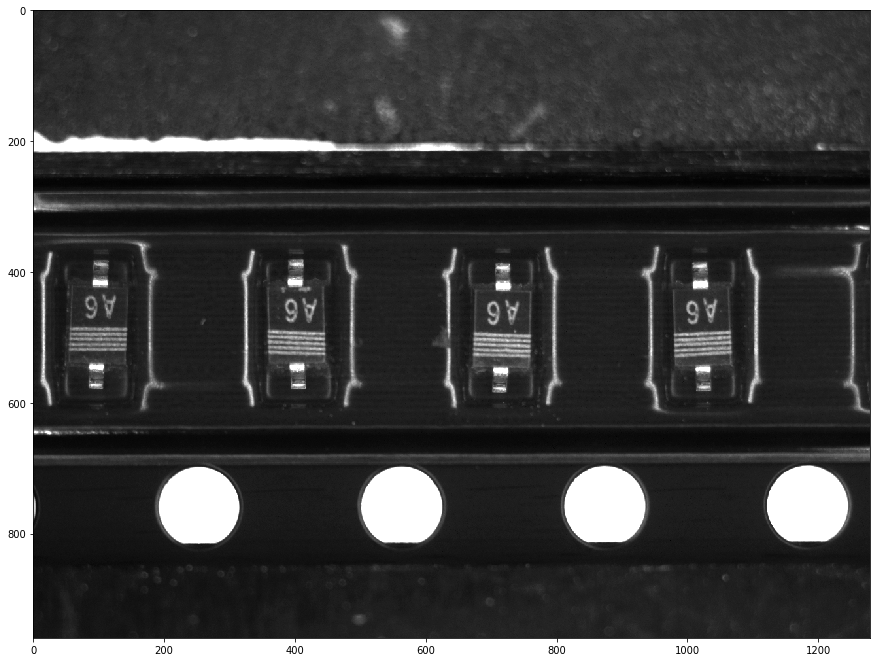

In [3]:
img=Image.open(path_rej+'WDP805134H4A_04_2_167.bmp')
img_np=np.array(img)
plt.figure(figsize=(15,15))
plt.imshow(img_np,'gray')
plt.show()

Crop the image by using the lightest position

In [3]:
# all items are in this area [h1:h2]
h1,h2=300,650
# w0 aims to crop the right side a little of the original image because there may have very bright place
w0=20
# using the mid line of the cropped image to decide the brightest place for left and right side
mid=(650-300)//2
def get_crop(image):
    img=Image.open(image)
    img=np.array(img)[h1:h2,:-w0]
    thres=np.where(img[mid]>60)[0]
    w1,w2=thres[0],thres[-1]
    pos=(w2-w1)//4
    crops=[]
    for i in range(4):
        img0=img[:,w1+i*pos:w1+(i+1)*pos]
        thres=np.where(img0[mid]>80)[0]
        w11,w22=thres[0],thres[-1]
        img0=img0[:,w11:w22]
        #mid1=(w22-w11)//2
        #thres=np.where(img0[:,mid1]>50)[0]
        #h11,h22=thres[0],thres[-1]
        #img0=img0[h11:h22,:]
        img0=Image.fromarray(img0)
        # resize the cropped image to (350,170)
        img0=img0.resize((170,350))
        img0=np.array(img0)
        crops.append(img0)
    return crops
def plot(crops,name):
    plt.subplots(1,4)
    plt.suptitle(name)
    for i,img0 in enumerate(crops):
        #img0=np.array(Image.fromarray(img0).resize((299,299)))
        plt.subplot(1,4,i+1)
        plt.imshow(img0,'gray')
        plt.axis('off')
    plt.show()

Plot some examples here

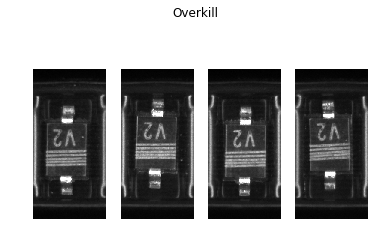

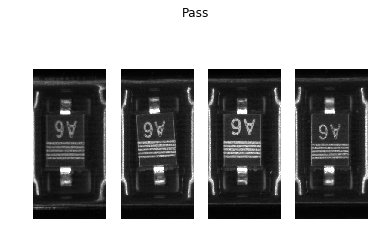

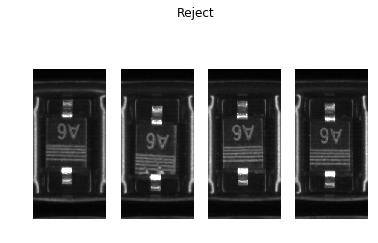

In [5]:
crops=get_crop(path_overkill+np.random.choice(overkill_img))
plot(crops,'Overkill')
plt.pause(0.1)
crops=get_crop(path_pass+np.random.choice(pass_img))
plot(crops,'Pass')
plt.pause(0.1)
crops=get_crop(path_rej+np.random.choice(rej_img))
plot(crops,'Reject')

Save the cropped image

In [ ]:
#pass_crops_path='./Pass_crops/'
#overkill_crops_path='./Overkill_crops/'
#rej_crops_path='./Reject_crops/'
#for crops_path in [pass_crops_path,overkill_crops_path,rej_crops_path]:
#    if not os.path.exists(crops_path):
#        os.makedirs(crops_path)
#for i,(name_set,crops_path,path) in enumerate(zip([pass_img,overkill_img,rej_img],
#                                                  [pass_crops_path,overkill_crops_path,rej_crops_path],
#                                                  [path_pass,path_overkill,path_rej])):
#    for name in name_set:
#        for j,crop in enumerate(get_crop(path+name)):
#            crop=Image.fromarray(crop)
#            crop.save(crops_path+name[:-4]+'@%d.jpg' % (j+1))

Select pass:overkill:rej=20000:10000:2000 for training data and 10000:5000:1000 for val and testing data

In [4]:
training_set=[]
val_set=[]
testing_set=[]
training_set.extend(pass_img[:20000])
training_set.extend(overkill_img[:10000])
training_set.extend(rej_img[:2000])
training_labels=[1]*20000+[-1]*10000+[0]*2000
val_set.extend(pass_img[20000:30000])
val_set.extend(overkill_img[10000:15000])
val_set.extend(rej_img[2000:3000])
val_labels=[1]*10000+[-1]*5000+[0]*1000
testing_set.extend(pass_img[30000:40000])
testing_set.extend(overkill_img[15000:20000])
testing_set.extend(rej_img[3000:4000])
testing_labels=[1]*10000+[-1]*5000+[0]*1000
#np.random.shuffle(training_set)
#np.random.shuffle(val_set)
#np.random.shuffle(testing_set)
print('training size: %d\n val size: %d\ntesting size: %d\n' % 
      (len(training_set),len(val_set),len(testing_set)))

training size: 32000
 val size: 16000
testing size: 16000



Read data and if label=1 the image is pass image,-1 for overkill,0 for reject.  

Training_data:(32000,238000)

Flatten the 4 cropped image to shape a feature for original image

In [5]:
pass_crops_path='./Pass_crops/'
overkill_crops_path='./Overkill_crops/'
rej_crops_path='./Reject_crops/'

In [6]:
from sklearn.linear_model import LogisticRegression
length=170*350
training_data=np.empty((32000,length*4))
val_data=np.empty((16000,length*4))
testing_data=np.empty((16000,length*4))


for i,(name_set,data,labels) in enumerate(zip([training_set,val_set,testing_set],
                                           [training_data,val_data,testing_data],
                                           [training_labels,val_labels,testing_labels])):
    for k,(name,label) in enumerate(zip(name_set,labels)):
        if label==1:
            path=pass_crops_path
        elif label==-1:
            path=overkill_crops_path
        else:
            path=rej_crops_path
        for j in range(4):
            img=np.array(Image.open(path+name[:-4]+'@%d.jpg' % (j+1)))
            data[k,j*length:(j+1)*length]=img.reshape(-1,)/255
            
training_labels_1=np.abs(np.abs(training_labels)-1)
val_labels_1=np.abs(np.abs(val_labels)-1)

Read image data by pytorch dataloader

Using logistic to set a baseline

fpr[np.where(tpr==1)[0][0]] should be lower than 0.14

In [7]:
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,roc_curve

In [8]:
def train(clf):
    clf.fit(training_data,training_labels_1)
    training_predictions=clf.predict(training_data)
    val_predictions=clf.predict(val_data)
    val_predictions_prob=clf.predict_proba(val_data)[:,1]

    print('training score: roc_auc: {:.4f} f1: {:.4f}'.format(roc_auc_score(training_labels_1,training_predictions),
                                                                          f1_score(training_labels_1,training_predictions)))
    print('training confusion matrix:\n',confusion_matrix(training_labels_1,training_predictions))
    print('val score: roc_auc: {:.4f} f1: {:.4f}'.format(roc_auc_score(val_labels_1,val_predictions),
                                                                          f1_score(val_labels_1,val_predictions)))
    print('prob auc score: {:.4f}'.format(roc_auc_score(val_labels_1,val_predictions_prob)))
    print('val confusion matrix:\n',confusion_matrix(val_labels_1,val_predictions))
    
    fpr,tpr,thres=roc_curve(val_labels_1,val_predictions_prob)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label='val')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print('optimal fpr: {:.4f} and thres: {}'.format(fpr[np.where(tpr==1)[0][0]],
                                                        thres[np.where(tpr==1)[0][0]]))
    return clf

training score: roc_auc: 0.9949 f1: 0.9593
training confusion matrix:
 [[29841   159]
 [   10  1990]]
val score: roc_auc: 0.9596 f1: 0.9075
prob auc score: 0.9781
val confusion matrix:
 [[14884   116]
 [   73   927]]


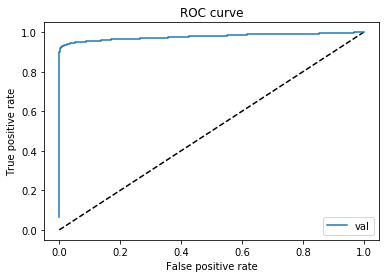

optimal fpr: 0.9999 and thres: 9.187648655771447e-16


In [12]:
clf=LogisticRegression(penalty='l2',solver='lbfgs',max_iter=50,class_weight='balanced',n_jobs=1)
clf=train(clf)

In [17]:
import pickle
with open('logistic50.pickle','wb') as f:
    pickle.dump(clf,f)
f.close()

In [18]:
import pickle
with open('logistic50.pickle','rb') as f:
    clf=pickle.load(f)
f.close()

Now, we look into the images that are accepted by logistic but rejected by human.

As well as the images that are rejected by both of logistic and human.

In [22]:
val_predictions=clf.predict(val_data)
val_predictions_prob=clf.predict_proba(val_data)[:,1]
error_idx=[i for i in range(len(val_labels_1)) if val_labels_1[i]==1 and val_predictions[i]==0]
val_predictions_prob_error=val_predictions_prob[error_idx]
error_sort_idx=np.argsort(val_predictions_prob_error)
right_idx=[i for i in range(len(val_labels_1)) if val_labels_1[i]==0 and val_predictions[i]==1]
val_predictions_prob_right=val_predictions_prob[right_idx]
right_sort_idx=np.argsort(-val_predictions_prob_right)

In [20]:
with open('mistake_logistic50_rej-pass.txt','a+') as f:
    for id0 in error_sort_idx:
        f.write(val_set[error_idx[id0]])
        f.write('\t'+str(val_predictions_prob_error[id0]))
        f.write('\n')
f.close()

In [23]:
with open('mistake_logistic50.txt_pass-rej','a+') as f:
    for id0 in right_sort_idx:
        f.write(val_set[right_idx[id0]])
        f.write('\t'+str(val_predictions_prob_right[id0]))
        f.write('\n')
f.close()

In [34]:
sum(1 for id0 in right_sort_idx if val_set[right_idx[id0]] in overkill_img)/len(right_sort_idx)

0.6120689655172413

WDP804157D5A_01_2_233.bmp , prob: 3.193256757161387e-09


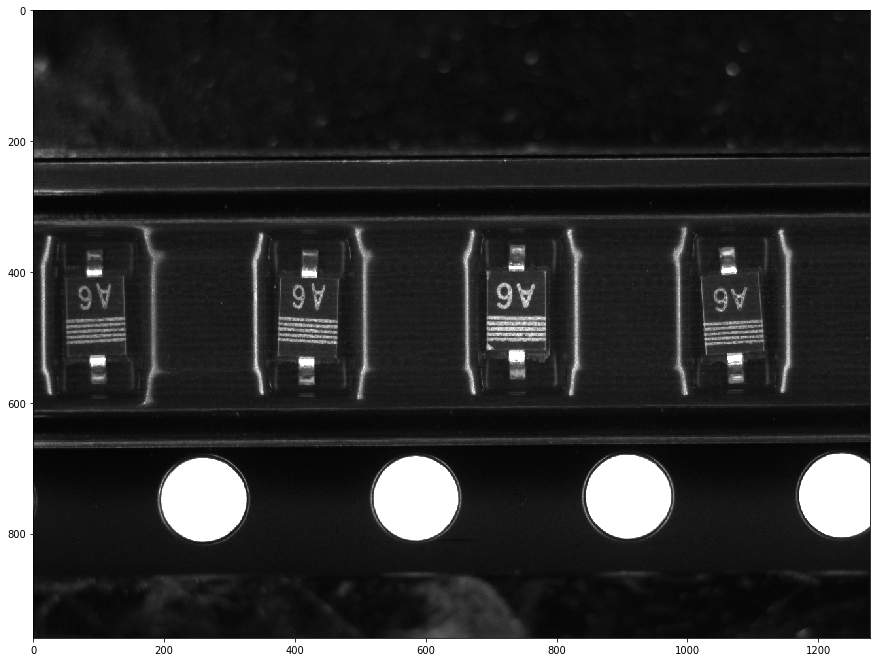

In [68]:
#idx=np.random.choice(error_idx)
idx=error_sort_idx[0]
img=Image.open(path_rej+val_set[error_idx[idx]])
print(val_set[error_idx[idx]],', prob:',val_predictions_prob_error[idx])
img_np=np.array(img)
plt.figure(figsize=(15,15))
plt.imshow(img_np,'gray')
plt.show()

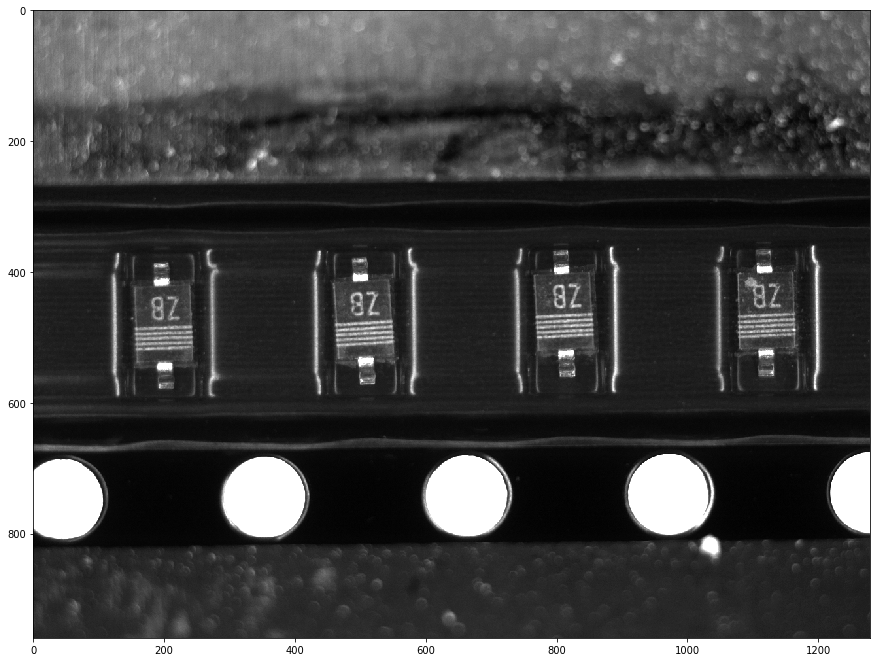

In [57]:
idx=np.random.choice(right_idx)
img=Image.open(path_rej+val_set[idx])
img_np=np.array(img)
plt.figure(figsize=(15,15))
plt.imshow(img_np,'gray')
plt.show()

Try some other parameters

training score: roc_auc: 0.9999 f1: 0.9990
training confusion matrix:
 [[29996     4]
 [    0  2000]]
val score: roc_auc: 0.9635 f1: 0.9418
prob auc score: 0.9784
val confusion matrix:
 [[14955    45]
 [   70   930]]


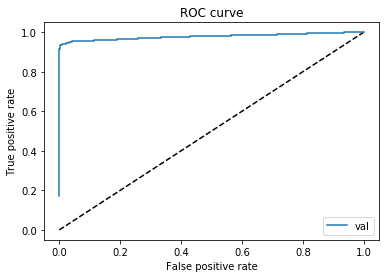

optimal fpr: 0.9836 and thres: 9.976041164715643e-16


In [71]:
clf=LogisticRegression(penalty='l2',solver='lbfgs',max_iter=100,class_weight='balanced',n_jobs=-1)
clf=train(clf)

The intersection between logistic50 and logistic 100

In [79]:
logis50=set()
with open('mistake_logistic50.txt','r') as f:
    for line in f.readline():
        logis50.add(f.readline().split('\t')[0])
f.close()
logis100=set()
with open('mistake_logistic100.txt','r') as f:
    for line in f.readline():
        logis100.add(f.readline().split('\t')[0])
f.close()
print(len(logis50.intersection(logis100))/len(logis50))

0.803921568627451


training score: roc_auc: 1.0000 f1: 1.0000
training confusion matrix:
 [[30000     0]
 [    0  2000]]
val score: roc_auc: 0.9375 f1: 0.9328
prob auc score: 0.9805
val confusion matrix:
 [[14999     1]
 [  125   875]]


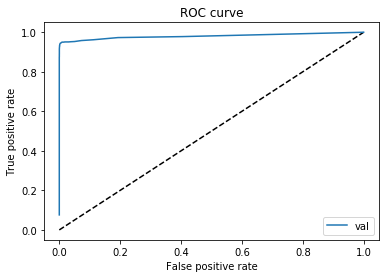

optimal fpr: 1.0000 and thres: 0.0


In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
clf=Pipeline([('clf_',RandomForestClassifier(n_estimators=100,n_jobs=-1,class_weight='balanced'))])
clf=train(clf)

This part is still working

pytorch CNN

In [24]:
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms,models
from torch.utils.data import DataLoader,Dataset,sampler
from aucmeter import AUCMeter
import time
import copy

In [25]:
class NexperiaData(Dataset):
    def __init__(self,name_set,paths,labels,transform=None):
        self.name_set=name_set
        self.paths=paths
        self.labels=labels
        self.transform=transform
    def __getitem__(self,idx):
        label=self.labels[idx]
        if label==1:
            path=self.paths[0]
        elif label==-1:
            path=self.paths[1]
        else:
            path=self.paths[2]
        img_stack=[]
        name=self.name_set[idx]
        for i in range(4):
            img=Image.open(path+name[:-4]+'@%d.jpg' % (i+1)).resize((224,224))
            img=np.repeat(np.array(img).transpose()[:,:,None],3,axis=2)
            if self.transform:
                img=self.transform(img)
            img_stack.append(img)
        img_stack=torch.stack(img_stack)
        #img_stack:(N,C,H,W)-->(4,3,170,350)
        return img_stack,abs(abs(label)-1)
    def __len__(self):
        return len(self.name_set)

In [26]:
batch_size=64
paths=[pass_crops_path,overkill_crops_path,rej_crops_path]
class_sample_count=np.bincount(np.abs(np.abs(training_labels)-1))
weights=np.array([1./class_sample_count[t] for t in np.abs(np.abs(training_labels)-1)])
weights=torch.from_numpy(weights)
sampler_balanced=sampler.WeightedRandomSampler(weights.double(),batch_size)

In [27]:
transformations=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.485,0.456,0.406],
                                                       [0.229,0.224,0.225])])
training_dataset=NexperiaData(training_set,paths,training_labels,transformations)
val_dataset=NexperiaData(val_set,paths,val_labels,transformations)
training_loader=DataLoader(training_dataset,batch_size,shuffle=False,sampler=sampler_balanced)
val_loader=DataLoader(val_dataset,batch_size,shuffle=False)
dataloaders={'train':training_loader,'val':val_loader}
dataset_sizes={'train':len(training_dataset),'val':len(val_dataset)}

In [28]:
dataset_sizes

{'train': 32000, 'val': 16000}

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_roc = 0.0
    best_proba=0
    best_tpr,best_fpr=0,0
    optim_fpr=1.
    auc_meter=AUCMeter()

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            auc_meter.reset()

            for data in dataloaders[phase]:
                img_stacks, labels = data

                img_stacks=img_stacks.view(-1,3,224,224)
                
                if phase=='train':
                    inputs = Variable(img_stacks.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs = Variable(img_stacks.cuda(),volatile=True)
                    labels = Variable(labels.cuda(),volatile=True)

                optimizer.zero_grad()

                outputs = model(inputs)

                probs=F.softmax(outputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()


                auc_meter.add(probs.data[:,1],labels.data)
                running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_roc,tpr,fpr = auc_meter.value()
            
            epoch_optim_fpr=fpr[np.where(tpr==1)[0][0]]
            

            print('{} Loss: {:.4f} Roc: {:.4f} Optim fpr: {:.4f}'.format(
                phase, epoch_loss, epoch_roc,epoch_optim_fpr))

            if phase == 'val' and epoch_optim_fpr < optim_fpr:
                best_roc = epoch_roc
                best_tpr,best_fpr=tpr,fpr
                optim_fpr=epoch_optim_fpr
                best_proba=auc_meter.scores
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Roc: {:4f} Optim fpr: {:.4f}'.format(best_roc,best_fpr[np.where(best_tpr==1)[0][0]]))

    model.load_state_dict(best_model_wts)
    return model,best_tpr,best_fpr,best_roc,best_proba

In [30]:
class resnet18_fc(nn.Module):
    def __init__(self,num_classes):
        super(resnet18_fc, self).__init__()
        resnet18=models.resnet18(pretrained=True)
        self.num_feat = resnet18.fc.in_features
        modules = list(resnet18.children())[:-1]
        self.resnet_feature = torch.nn.Sequential(*modules).cuda()
        self.fc=nn.Linear(4*self.num_feat,num_classes)

    def forward(self, img_stacks):
        # img_stacks:(batch_size*4,3,224,224)
        out=self.resnet_feature(img_stacks)
        # out:(batch_size*4,512)
        out=out.view(batch_size,4*self.num_feat)
        out=self.fc(out)
        # out:(batch_size,2)
        return out

In [32]:
resnet18=resnet18_fc(num_classes=2).cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=1e-3)

In [33]:
model,tpr,fpr,roc,proba=train_model(resnet18,criterion,optimizer,exp_lr_scheduler)

Epoch 0/29
----------


/usr/local/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.0074 Roc: 0.4873 Optim fpr: 1.0000
val Loss: 1.4835 Roc: 0.7229 Optim fpr: 0.9979

Epoch 1/29
----------
train Loss: 0.0043 Roc: 0.8828 Optim fpr: 0.5938
val Loss: 1.4710 Roc: 0.8382 Optim fpr: 0.9799

Epoch 2/29
----------
train Loss: 0.0035 Roc: 0.9034 Optim fpr: 0.9714
val Loss: 1.4745 Roc: 0.8858 Optim fpr: 0.9437

Epoch 3/29
----------
train Loss: 0.0030 Roc: 0.9281 Optim fpr: 0.3143
val Loss: 1.4476 Roc: 0.9075 Optim fpr: 0.9442

Epoch 4/29
----------
train Loss: 0.0030 Roc: 0.9054 Optim fpr: 0.7714
val Loss: 1.5241 Roc: 0.9209 Optim fpr: 0.9403

Epoch 5/29
----------
train Loss: 0.0018 Roc: 0.9727 Optim fpr: 0.1875
val Loss: 1.5369 Roc: 0.9332 Optim fpr: 0.9447

Epoch 6/29
----------
train Loss: 0.0025 Roc: 0.9409 Optim fpr: 0.6486
val Loss: 1.7107 Roc: 0.9437 Optim fpr: 0.9495

Epoch 7/29
----------
train Loss: 0.0017 Roc: 0.9736 Optim fpr: 0.4516
val Loss: 1.9796 Roc: 0.9532 Optim fpr: 0.9569

Epoch 8/29
----------
train Loss: 0.0015 Roc: 0.9746 Optim fpr: 0.5152